# Closed-source Experiments

In this notebook, we will show you how you can run the closed-source models from our experiments on COLUMBUS. These models are: **GPT-4o**, **GPT-4o (mini)**, **Gemini 1.5 Pro**, and **Gemini 1.5 Flash**. All results computed in this notebook will be stored under the `model_results` folder (found in the same directory as this notebook).

## Setup
To get started, run the setup as shown below.

In [2]:
# Add root folder to allow module imports
import sys
sys.path.append("../")

In [3]:
# Import Python modules
import os
import json
import random

# Import tqdm for progress bars
from tqdm import tqdm

# Import COLUMBUS benckmark
from puzzles.Benchmark import Benchmark

The following code can be tweaked to alter the number of puzzles which the models will run on (first *n* puzzles), as well as the prompts that will be used. These prompts correspond to prompt 2 from the paper, which includes a description on the nature of the puzzle being solved.

In [4]:
# Number of puzzles to run models on (defined as first n puzzles) 
# This variable must be between 1 and 1008 (1008 is the number of puzzles in COLUMBUS)
N_PUZZLES = 1
assert N_PUZZLES > 0 and N_PUZZLES <= 1008

# Prompt used for regular prompting (i.e., without forward/backward chaining)
PROMPT_TEMPLATE = "You are given a rebus puzzle. It consists of text or icons that is used to convey a word or phrase. It needs to be solved through creative thinking. Which word/phrase is conveyed in this image from the following options (either A, B, C, or D)?\n(A) {} (B) {} (C) {} (D) {}"

# Prompts used for forward chaining
JSON_PROMPT = "This image is a rebus puzzle which contains more than one item. An item can be text, icons or shapes. Describe all items in the image in a json file. Each item should have a sepearte json file. The json file should have the following format: {'id': 'temperal_id', 'name' : 'name_of_the_item', 'description': 'description_of_the_item', 'relation': 'location_relation_to_other_items','specialy': 'specialy_of_the_item_if_any'}. The 'specialy' field should be something you found special or different from normal items."
REASON_PROMPT_TEMPLATE = """The image is a rebus puzzle which contain a word or phrases. Here is a json file describing the item in the image.
{}
Which word/phrase is conveyed in this image from the following options (either A, B, C, or D)? \n(A) {} (B) {} (C) {} (D) {}
Start your reasoning by mapping each json file to the word in the answer choices. Only pick the answer choice that is consistent with all the json file."""

## OpenAI Models (GPT-4o + GPT-4o-mini)

The following section will run GPT-4o and GPT-4o-mini on COLUMBUS. This requires an API key provided by OpenAI, which you can change below. By default, this will select an environment variable under the name `OPENAI_API_KEY`, but you can also set this to a string defining the API key. You can also change the `GPT4_MODEL` variable to switch between GPT-4o and GPT-4o-mini (this must be equal to either `gpt-4o` or `gpt-4o-mini`).

In [5]:
# Variable for OpenAI API key (change this if you do not have the environment variable set)
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# Variable for which GPT-4o model to run (either "gpt-4o" or "gpt-4o-mini")
GPT4_MODEL = "gpt-4o"
assert GPT4_MODEL == "gpt-4o" or GPT4_MODEL == "gpt-4o-mini"

In [ ]:
# Import function to prompt GPT-4o API
from notebook_util import prompt_gpt4

# Get puzzles from the benchmark
benchmark = Benchmark(with_metadata=True)
puzzles = benchmark.get_puzzles()

# Loop over N_PUZZLES puzzles and prompt GPT-4o(-mini) to solve the given puzzle
for puzzle in tqdm(puzzles[:N_PUZZLES], desc=f"Prompting {GPT4_MODEL}"):
    # Get path to image and options
    image = puzzle["image"]
    options = puzzle["options"]

    # Format the prompt
    prompt_format = list(options.values())
    prompt = PROMPT_TEMPLATE.format(*prompt_format)
    puzzle["prompt"] = prompt

    # Prompt GPT-4o(-mini)
    response = prompt_gpt4(prompt, image, GPT4_MODEL, OPENAI_API_KEY)
    puzzle["output"] = response

# Save results under the 'model_results' folder
with open(f"./model_results/{GPT4_MODEL.lower()}_prompt_2.json", "w") as file:
    json.dump(puzzles, file, indent=3)

### Forward chaining

The following code will run the forward chaining variant of GPT-4o(-mini) on COLUMBUS.

In [ ]:
# Import function to prompt GPT-4o API
from notebook_util import prompt_gpt4

# Get puzzles from the benchmark
benchmark = Benchmark(with_metadata=True)
puzzles = benchmark.get_puzzles()

# Loop over N_PUZZLES puzzles and prompt GPT-4o(-mini) to solve the given puzzle
for puzzle in tqdm(puzzles[:N_PUZZLES], desc=f"Prompting {GPT4_MODEL} (forward chaining)"):
    # Get path to image and options
    image = puzzle["image"]
    options = puzzle["options"]

    # Prompt GPT-4o(-mini) for a JSON file with information on the puzzle
    json_response = prompt_gpt4(JSON_PROMPT, image, GPT4_MODEL, OPENAI_API_KEY)    

    # Prompt GPT-4o(-mini) to solve the puzzle given the JSON file
    prompt_format = [json_response] + list(options.values())
    prompt = REASON_PROMPT_TEMPLATE.format(*prompt_format)
    puzzle["prompt"] = prompt
    response = prompt_gpt4(prompt, image, GPT4_MODEL, OPENAI_API_KEY)
    puzzle["output"] = response

# Save results under the 'model_results' folder
with open(f"./model_results/{GPT4_MODEL.lower()}_fc_prompt_2.json", "w") as file:
    json.dump(puzzles, file, indent=3)

### Backward Chaining

The following code will run the backward chaining variant (through belief graphs) of GPT-4o(-mini) on COLUMBUS. 

For this approach, there is also an opportunity to visualize the belief graph after it has been fixed (set `visualize_graph` to `True` to do so). This requires pygraphviz, which can be be installed through conda: `conda install --channel conda-forge pygraphviz`. The graph can be interpreted as follows:
- Square nodes (⬛) are statement nodes, which has the following properties:
    - They are a statement expressing a belief (i.e., does the model believe X to be true?).
    - They contain a truth assignment (<span style="color:green">green</span> = true, <span style="color:red">red</span> = false).
    - They contain a confidence that the assigned truth value is accurate (between 0 and 1).
- Circular nodes (⚫) are rule nodes, which have the following properties:
    - They connect statement nodes to each other. Statement nodes from incoming edges represent premises, and the statement node from the outgoing edge represent the hypothesis.
    - They contain a confidence that the premises imply the hypothesis (between 0 and 1).
  

**NOTE**: this approach will incur high API costs, as solving a single puzzle will usually require around 20+ prompts.

Prompting gpt-4o (backward chaining):   0%|                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]


=== GRAPH DESCRIPTION ===
STATEMENT (id: 1, value: False, confidence: 0.00) - "The word/phrase conveyed in this image is "jet set"."
STATEMENT (id: 2, value: True, confidence: 0.62) - "The word/phrase conveyed in this image is not "jet set"."
STATEMENT (id: 5, value: True, confidence: 0.99) - "The word "JET" is directly presented in the image."
STATEMENT (id: 6, value: False, confidence: 0.00) - "The word "JET" is followed by the word "ET," with "SET" following logically from the word "JET" in the rebus puzzle format."
STATEMENT (id: 8, value: False, confidence: 0.01) - "The image shows the word "JET" with a letter "E" and "T" forming a visual pattern indicating "JET" and the letter "T" right after it, which visually represents the phrase "JET T"."
STATEMENT (id: 9, value: True, confidence: 0.22) - "The combination visually and phonetically matches "JET + T" (Jet Tea) rather than "jet set" which would require additional elements or rearrangement not present in the image."
STATEMENT (i

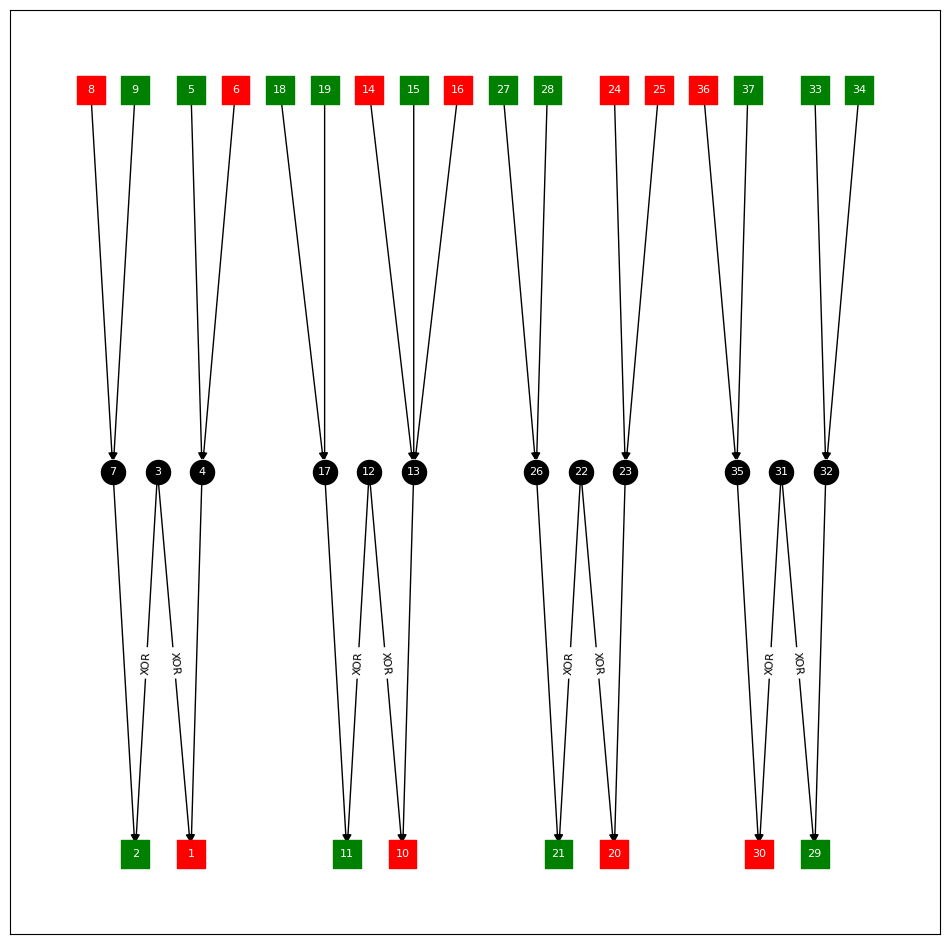

Prompting gpt-4o (backward chaining): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:44<00:00, 104.38s/it]


In [9]:
# Import code necessary to run the backward chaining approach through belief graphs.
from graphs.BeliefGraphGenerator import BeliefGraphGenerator
from graphs.BeliefGraphReasoner import BeliefGraphReasoner

# Set the seed
seed = 43
random.seed(seed)

# Load benchmark and sample min(N_PUZZLES, 50) random puzzles
benchmark = Benchmark()
puzzles = random.sample(benchmark.get_puzzles(), min(N_PUZZLES, 50))

# Define hyperparameters
max_depth = 1
hyperparameters = {
    "k": 9,
    "k_entailer": 36,
    "k_xor": 30,
    "k_mc": 9,
    "t_entailer": 1.02,
    "t_xor": 1.1,
    "t_mc": 0.98,
    "m_xor": 0.3,
    "c_xor": 1.,
    "c_mc": 1.
}

visualize_graph = True

# Loop over puzzles, generate a belief graph for it, and optimize the graph to solve the given puzzle
for puzzle in tqdm(puzzles, desc=f"Prompting {GPT4_MODEL} (backward chaining)"):
    # Get path to image and options
    image = puzzle["image"]
    options = list(puzzle["options"].values())

    # Generate a belief graph
    generator = BeliefGraphGenerator(image, 0, options, hyperparameters, max_depth=max_depth, model=GPT4_MODEL)
    graph = generator.generate_graph()

    # Optimize belief graph by fixing logical conflicts
    reasoner = BeliefGraphReasoner(hyperparameters)
    graph, _ = reasoner.fix_graph(graph)

    if visualize_graph:
        print(graph)
        graph.visualize(show=True)

    # Compute answer
    answer_csp = graph.get_answer()
    puzzle["output"] = answer_csp

# Save results under the 'model_results' folder
with open(f"./model_results/{GPT4_MODEL.lower()}_bc_prompt_2.json", "w") as file:
    json.dump(puzzles, file, indent=3)

## Google Models (Gemini 1.5 Pro + Flash)

Similarly, the following section will run Gemini 1.5 Pro and Gemini 1.5 Flash on COLUMBUS. This requires an API key provided by Google, which you can change below. By default, this will select an environment variable under the name `GOOGLE_API_KEY`, but you can also set this to a string defining the API key. You can also change the `GEMINI_MODEL` variable to switch between Gemini 1.5 Pro and Flash (this must be equal to either `gemini-1.5-pro` or `gemini-1.5-flash`).

In [ ]:
# Variable for Google API key (change this is you do not have the environment variable set)
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")

# Variable for which Gemini model to run (either "gemini-1.5-pro" or "gemini-1.5-flash")
GEMINI_MODEL = "gemini-1.5-pro"
assert GEMINI_MODEL == "gemini-1.5-pro" or GEMINI_MODEL == "gemini-1.5-flash"

In [ ]:
# Import function to prompt the Gemini API
from notebook_util import prompt_gemini

# Get puzzles from the benchmark
benchmark = Benchmark(with_metadata=True)
puzzles = benchmark.get_puzzles()

# Loop over N_PUZZLES puzzles and prompt Gemini-1.5 to solve the given puzzle
for puzzle in tqdm(puzzles[:N_PUZZLES], desc=f"Prompting {GEMINI_MODEL}"):
    # Get path to image and options
    image = puzzle["image"]
    options = puzzle["options"]

    # Format prompt
    prompt_format = list(options.values())
    prompt = PROMPT_TEMPLATE.format(*prompt_format)
    puzzle["prompt"] = prompt

    # Prompt Gemini 1.5 (Pro/Flash)
    response = prompt_gemini(prompt, image, GEMINI_MODEL, GOOGLE_API_KEY, verbose=True)
    puzzle["output"] = response

# Save results under the 'model_results' folder
with open(f"./model_results/{GEMINI_MODEL.lower()}_prompt_2.json", "w") as file:
    json.dump(puzzles, file, indent=3)

### Forward chaining

The following code will run the forward chaining variant of Gemini 1.5 Pro/Flash on COLUMBUS.

In [ ]:
# Import function to prompt the Gemini API
from notebook_util import prompt_gemini

# Get puzzles from the benchmark
benchmark = Benchmark(with_metadata=True)
puzzles = benchmark.get_puzzles()

# Loop over N_PUZZLES puzzles and prompt Gemini-1.5 to solve the given puzzle
for puzzle in tqdm(puzzles[:N_PUZZLES], desc=f"Prompting {GEMINI_MODEL}"):
    # Get path to image and options
    image = puzzle["image"]
    options = puzzle["options"]

    # Prompt Gemini 1.5 (Pro/Flash) for a JSON file with information on the puzzle
    json_response = prompt_gemini(JSON_PROMPT, image, GEMINI_MODEL, GOOGLE_API_KEY)    

    # Prompt Gemini 1.5 (Pro/Flash) to solve the puzzle given the JSON file
    prompt_format = [json_response] + list(options.values())
    prompt = REASON_PROMPT_TEMPLATE.format(*prompt_format)
    puzzle["prompt"] = prompt
    response = prompt_gemini(prompt, image, GEMINI_MODEL, GOOGLE_API_KEY)
    puzzle["output"] = response

# Save results under the 'model_results' folder
with open(f"./model_results/{GEMINI_MODEL.lower()}_fc_prompt_2.json", "w") as file:
    json.dump(puzzles, file, indent=3)